# SVM with rbf kernel

The goal of this notebook is to find the best parameters for polynomial kernel. We also want to check if the parameters depend on stock.

We will use [sklearn.svm](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) library to perform calculations. We want to pick the best parameters for **SVC**:

* C (default 1.0)
* gamma (default 1/number_of_features, so 1 in our case)

Kernel function looks like this: $\exp(-\gamma \|x-x'\|^2)$. $\gamma$ is specified by keyword **gamma**, must be greater than 0.

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['9058', '13003',  '9074', '11244', '9270']

dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_prepared_data(s, cv=True)
    dfs[s] = df
    dfs_cv[s] = df_cv
    dfs_test[s] = df_test

Training set length for 9058: 3030
Testing set length for 9058: 1010
Cross-validation set length for 9058: 1010
Training set length for 13003: 3030
Testing set length for 13003: 1010
Cross-validation set length for 13003: 1010
Training set length for 9074: 3030
Testing set length for 9074: 1010
Cross-validation set length for 9074: 1010
Training set length for 11244: 3030
Testing set length for 11244: 1010
Cross-validation set length for 11244: 1010
Training set length for 9270: 3030
Testing set length for 9270: 1010
Cross-validation set length for 9270: 1010


In [3]:
dfs[stocks[0]].head(5)

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
1010,2013-09-05 10:42:00,"[(1000.0, 400.0), (1260.0, 400.0), (1350.0, 50...","[(1887.5, 2900.0), (1888.0, 6402.0), (1888.5, ...",1886.5,1887.5,1887.00,2900.0,915.0,1.0,-0.520315
1011,2013-09-05 10:43:00,"[(1000.0, 400.0), (1260.0, 400.0), (1350.0, 50...","[(1888.5, 4392.0), (1889.0, 9866.0), (1889.5, ...",1887.0,1888.5,1887.75,4392.0,1766.0,0.0,-0.426437
1012,2013-09-05 10:44:00,"[(1000.0, 400.0), (1260.0, 400.0), (1350.0, 50...","[(1888.0, 104.0), (1888.5, 8793.0), (1889.0, 7...",1887.0,1888.0,1887.50,104.0,2675.0,1.0,0.925153
1013,2013-09-05 10:45:00,"[(1000.0, 400.0), (1260.0, 400.0), (1350.0, 50...","[(1889.5, 3407.0), (1890.0, 9268.0), (1890.5, ...",1888.0,1889.5,1888.75,3407.0,4090.0,1.0,0.091103
1014,2013-09-05 10:46:00,"[(1000.0, 400.0), (1260.0, 400.0), (1350.0, 50...","[(1890.0, 1395.0), (1890.5, 11305.0), (1891.0,...",1889.0,1890.0,1889.50,1395.0,2195.0,1.0,0.222841


In [4]:
def svm_classification(d, kernel, gamma='auto', C=1.0):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Methodology

We will use at first naive approach to grasp how each of the parameter influences the ROC area score and what values make sense, when the other parameters are set to defaults.

After that we will try to get the best combination of the parameters.

### C parameter

The C parameter has influence over margin picked by SVM:
* for large values of **C** SVM will choose a smaller-margin hyperplane, which means that more data points will be classified correctly
* for small values of **C** SVM will choose a bigger-margin hyperplane, so there may be more misclassifications

At first we tried parameters: [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000], but after first calculations it seems that it wasn't enough, so a few more values were introduced or removed.

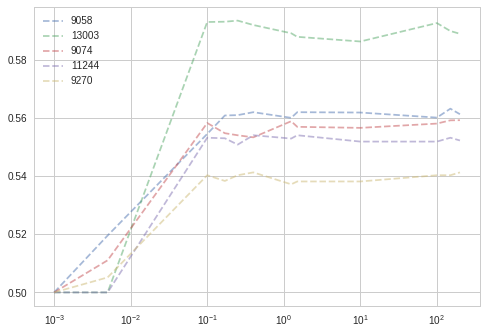

In [5]:
cs = [0.001, 0.005, 0.1, 0.17, 0.25, 0.4, 1.25, 1.5, 10, 100, 150, 200]
df_css = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_cs = pd.DataFrame(index=cs)
    df_cs['roc'] = np.zeros(len(df_cs))
    for c in cs:
        reg_svm = svm_classification(dfs[s], 'rbf', C=c)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_cs.loc[c] = logit_roc_auc
    plt.plot(df_cs, linestyle='--', label=s, marker='x', alpha=0.5)
    df_css[s] = df_cs
    
plt.legend()

##### Best values of C parameter

In [6]:
for s in stocks:
    idx = df_css[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 9058 the best is 150.0
For 13003 the best is 0.25
For 9074 the best is 200.0
For 11244 the best is 0.4
For 9270 the best is 0.4


##### Influence of C parameter

In [7]:
for s in stocks:
    err_max = df_css[s]['roc'].max()
    err_min = df_css[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 9058 the diff between best and worst 0.06315583014612136
For 13003 the diff between best and worst 0.09342933161458677
For 9074 the diff between best and worst 0.05920205920205923
For 11244 the diff between best and worst 0.054020648538607
For 9270 the diff between best and worst 0.041254901960784296


### Gamma

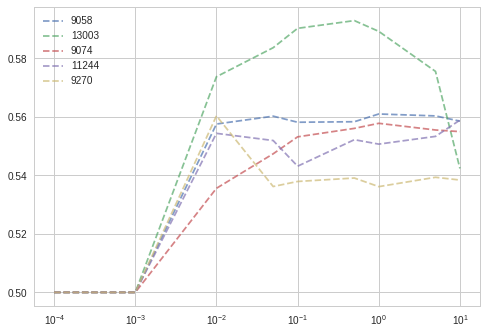

In [8]:
gammas = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]

df_gammas = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_gamma = pd.DataFrame(index=gammas)
    df_gamma['roc'] = np.zeros(len(df_gamma))
    for g in gammas:
        reg_svm = svm_classification(dfs[s], 'rbf', gamma=g)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))

        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_gamma.loc[g] = logit_roc_auc
    plt.plot(df_gamma, linestyle='--', label=s, marker='x', alpha=0.7)
    df_gammas[s] = df_gamma
    
plt.legend()

##### Best values of gamma

In [9]:
for s in stocks:
    idx = df_gammas[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 9058 the best is 1.0
For 13003 the best is 0.5
For 9074 the best is 1.0
For 11244 the best is 10.0
For 9270 the best is 0.01


##### Influence of gamma

In [10]:
for s in stocks:
    err_max = df_gammas[s]['roc'].max()
    err_min = df_gammas[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 9058 the diff between best and worst 0.0610179464548396
For 13003 the diff between best and worst 0.09295182924672529
For 9074 the diff between best and worst 0.05782873465800287
For 11244 the diff between best and worst 0.058931259309331185
For 9270 the diff between best and worst 0.06037254901960776


# Results

We compare results of the SVMs with the best choices of parameters against the logistic regression and SVM with defaults.

We will use two approaches for choosing parameters:
* naive - for each stock we will just pick the best values we found in the previous section
* grid - we will caluclate roc_area error for every combination of parameters used in previous section (computionally heavy).

We could also use GridSearchCV from sklearn library, but the issue with it is supplying the cross-validation set (it has to be continous in time). In the future we need to implement the method for that.

#### Naive approach

We pick the best **C** parameter and the best **gamma** separately from the results of [section above](#Methodology), which were obtained using cross-validation set.

In [11]:
df_results = pd.DataFrame(index=stocks)
df_results['logistic'] = np.zeros(len(stocks))
df_results['rbf-naive'] = np.zeros(len(stocks))
df_results['rbf-default'] = np.zeros(len(stocks))

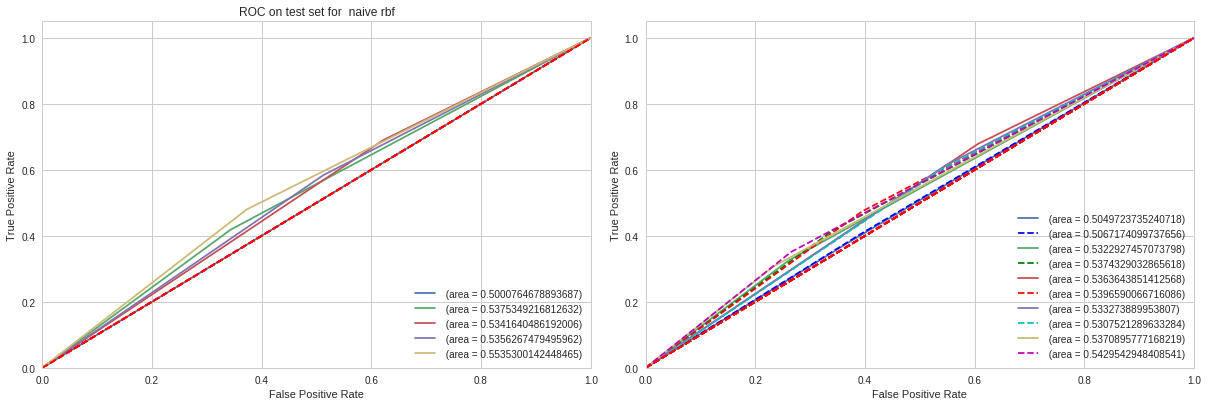

In [12]:
plt.subplot(121)

for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf', C=df_css[s]['roc'].idxmax(), gamma=df_gammas[s]['roc'].idxmax())
    score = lob.plot_roc(dfs_test[s], reg_svm, title='ROC on test set for  naive rbf')
    df_results['rbf-naive'][s] = score

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf')
    score = lob.plot_roc(dfs_test[s], reg_svm, title='ROC on test set for default')
    df_results['rbf-default'][s] = score

    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    score = lob.plot_roc(dfs_test[s], reg_log, c=colors[stocks.index(s)], linestyle='--')
    df_results['logistic'][s] = score
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [13]:
df_results

,logistic,rbf-naive,rbf-default
9058,0.506717,0.500076,0.504972
13003,0.537433,0.537535,0.532293
9074,0.539659,0.534164,0.536364
11244,0.530752,0.535627,0.533274
9270,0.542954,0.553530,0.537090


### Grid approach

We iterate over all combinations of parameters **C** and **gamma**.

This approach works usually better, but not for all cases.

In [14]:
df_params = {}

for s in stocks:
    print(s)
    params = []
    for c in cs:
        for g in gammas:
            reg_svm = svm_classification(dfs[s], 'rbf', C=c, gamma=g)
            prediction = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
            score = roc_auc_score(dfs_cv[s]['mid_price_indicator'], prediction)
            params.append({'score': score, 'gamma': g, 'c': c})
    df_params[s] = pd.DataFrame(params)
df_params[stocks[0]]

9058
13003
9074
11244
9270


,c,gamma,score
0,0.001,0.0001,0.500000
1,0.001,0.0010,0.500000
2,0.001,0.0100,0.500000
3,0.001,0.0500,0.500000
4,0.001,0.1000,0.500000
5,0.001,0.5000,0.500000
6,0.001,1.0000,0.500000
7,0.001,5.0000,0.500000
8,0.001,10.0000,0.500000
9,0.005,0.0001,0.500000


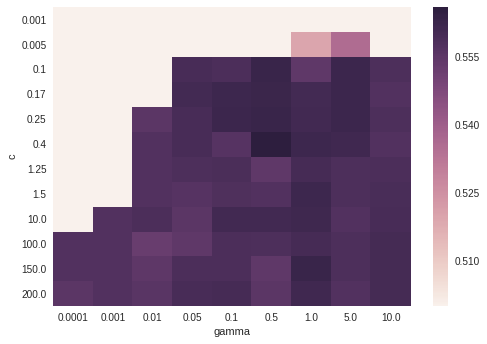

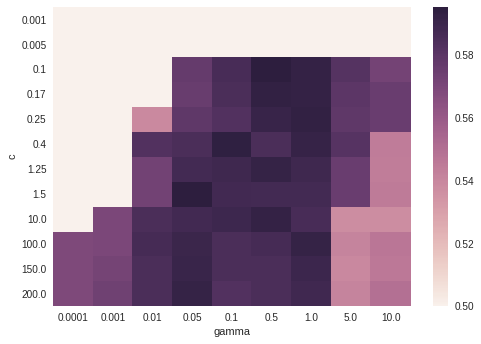

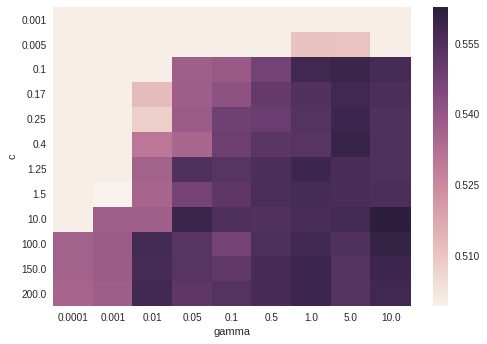

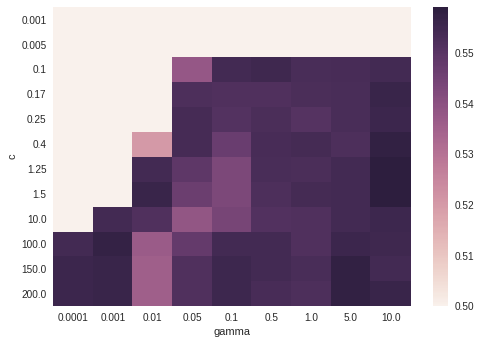

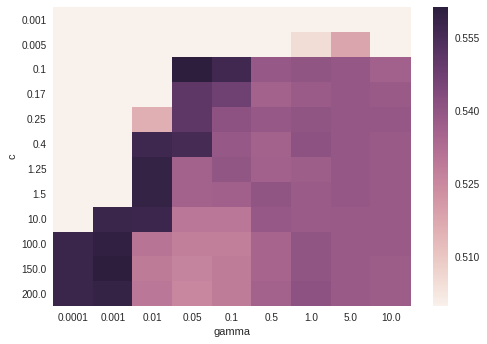

In [15]:
for s in stocks:
    df_g = df_params[s].pivot(index='c', columns='gamma', values='score')
    sns.heatmap(df_g)
    plt.figure()

##### Best parameters for grid approach

In [16]:
for s in stocks:
    print(df_params[s].iloc[df_params[s]['score'].idxmax()])

c        0.400000
gamma    0.500000
score    0.566059
Name: 50, dtype: float64
c        0.100000
gamma    0.500000
score    0.595408
Name: 23, dtype: float64
c        10.0000
gamma    10.0000
score     0.5628
Name: 80, dtype: float64
c         1.250000
gamma    10.000000
score     0.559026
Name: 62, dtype: float64
c        0.100000
gamma    0.050000
score    0.561333
Name: 21, dtype: float64


9058 50
	 0.4 0.5
13003 23
	 0.1 0.5
9074 80
	 10.0 10.0
11244 62
	 1.25 10.0
9270 21
	 0.1 0.05


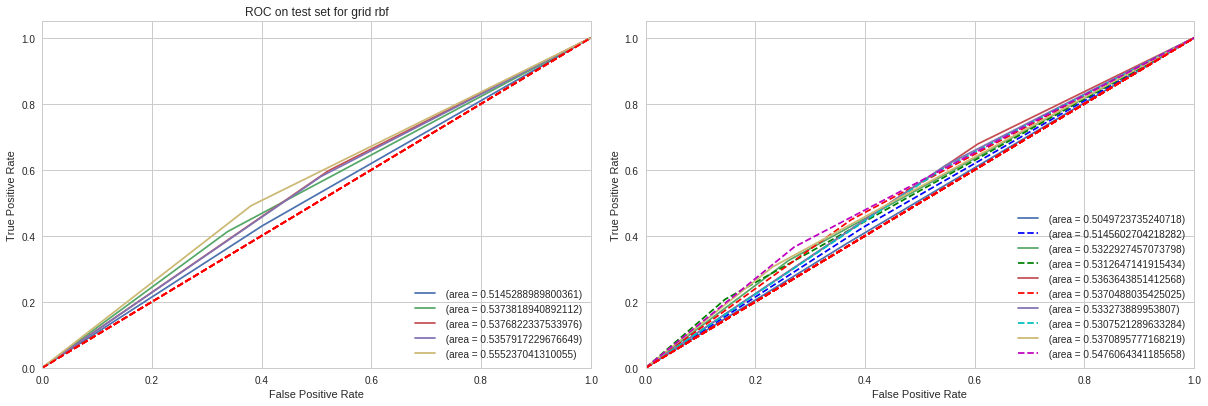

In [17]:
df_results['rbf-grid'] = np.zeros(len(stocks))

plt.subplot(121)
for s in stocks:
    best_idx = df_params[s]['score'].idxmax()
    print(s, best_idx)
    print('\t', df_params[s]['c'].iloc[best_idx], df_params[s]['gamma'].iloc[best_idx])
    reg_svm = svm_classification(dfs[s], 'rbf', C=df_params[s].iloc[best_idx]['c'], 
                                 gamma=df_params[s].iloc[best_idx]['gamma'])
    score = lob.plot_roc(dfs_test[s], reg_svm, title='ROC on test set for grid rbf')
    df_results['rbf-grid'][s] = score

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf')
    score = lob.plot_roc(dfs_test[s], reg_svm, title='ROC on test set for default')
    df_results['rbf-default'][s] = score

    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    score = lob.plot_roc(dfs_test[s], reg_log, c=colors[stocks.index(s)], linestyle='--')
    df_results['logistic'][s] = score
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [18]:
df_results

,logistic,rbf-naive,rbf-default,rbf-grid
9058,0.514560,0.500076,0.504972,0.514529
13003,0.531265,0.537535,0.532293,0.537382
9074,0.537049,0.534164,0.536364,0.537682
11244,0.530752,0.535627,0.533274,0.535792
9270,0.547606,0.553530,0.537090,0.555237


# Conclusions

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a>
2. [RBF kernel](https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/)
3. [model_selection.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)